In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


In [2]:
SEED = 123
DRAWS = 10000
BURNIN = 2000
TUNE = 2000
CHAINS = 4
CORES = 2

# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [3]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

Reaction  Days Subject
1   249.5600     0     308
2   258.7047     1     308
3   250.8006     2     308
4   321.4398     3     308
5   356.8519     4     308
6   414.6901     5     308
7   382.2038     6     308
8   290.1486     7     308
9   430.5853     8     308
10  466.3535     9     308
11  222.7339     0     309
12  205.2658     1     309
13  202.9778     2     309
14  204.7070     3     309
15  207.7161     4     309

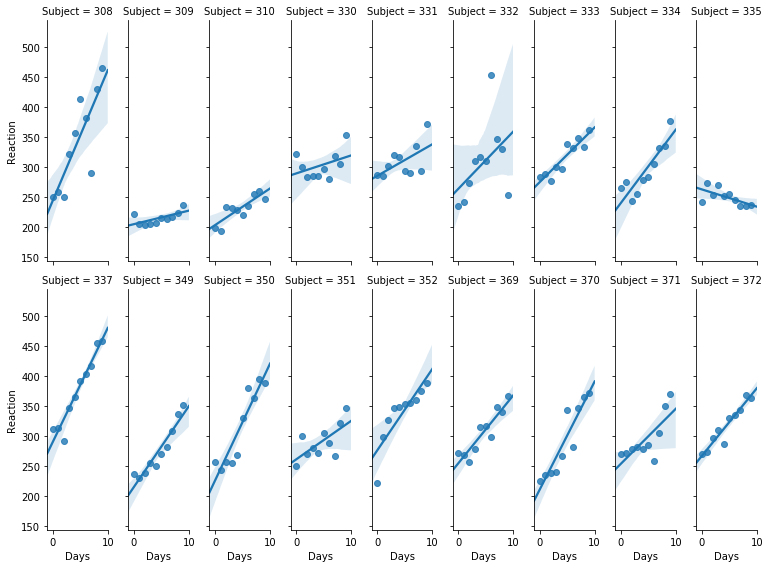

In [4]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Model 1: Random effect on only the intercepts

Design matrix for the fixed effect

In [5]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

Design matrix for the random effect (intercept only). This means that each subject will deviate from the average intercecpt by some amount, but the slope will be the same across participants

In [6]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [8]:
with pm.Model() as model_intercept:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    scaler_Z = pm.HalfNormal('scaler_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, scaler_Z, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


In [9]:
trace_intercept = trace_intercept[BURNIN: ]

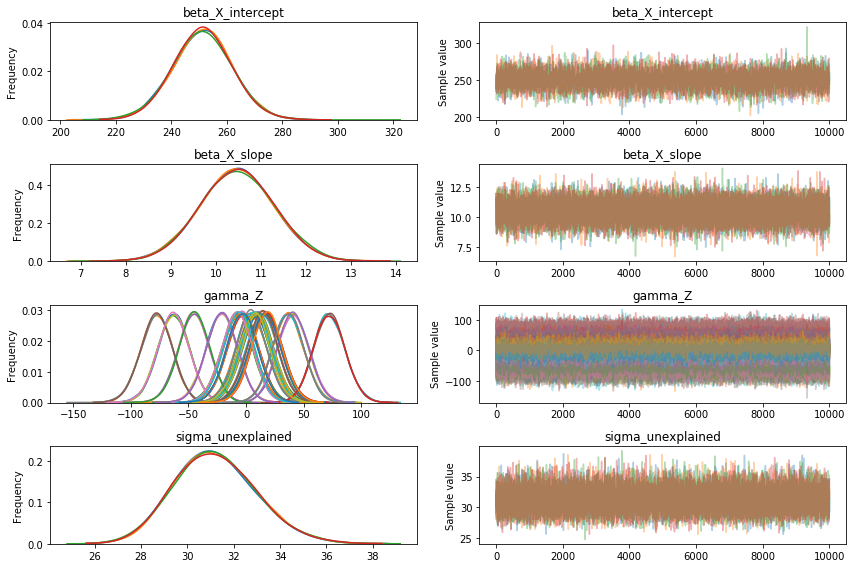

In [10]:
_ = pm.traceplot(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained'])

In [11]:
pm.summary(trace_intercept)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope        10.470077   0.805757  0.003988    8.859402   12.008640   
gamma_Z_raw__0       1.058464   0.379521  0.004058    0.330926    1.807648   
gamma_Z_raw__1      -2.012510   0.474404  0.004725   -2.948383   -1.102285   
gamma_Z_raw__2      -1.629300   0.433214  0.004342   -2.479027   -0.792959   
gamma_Z_raw__3       0.117816   0.342153  0.003572   -0.552521    0.788892   
gamma_Z_raw__4       0.267926   0.341242  0.003587   -0.409412    0.930688   
gamma_Z_raw__5       0.217199   0.341637  0.003784   -0.453843    0.892965   
gamma_Z_raw__6       0.430668   0.346924  0.003773   -0.240260    1.119835   
gamma_Z_raw__7      -0.072773   0.338668  0.003455   -0.721218    0.607502   
gamma_Z_raw__8      -1.167791   0.390311  0.003963   -1.920215   -0.394215   
gamma_Z_raw__9       1.871161   0.454594  0.005021    0.990238    2.770863   
gamma_Z_raw__10     -0.545645   0.351532  0.003624   -1.247067    0.125316   
gamma_Z_raw__11      0.367309   0.345659  0.003618   -0.314603    1.040524   
gamma_Z_raw__12     -0.200574   0.340649  0.003408   -0.876968    0.463227   
gamma_Z_raw__13      0.946291   0.371771  0.003873    0.226228    1.682205   
gamma_Z_raw__14      0.185272   0.340336  0.003574   -0.464948    0.862500   
gamma_Z_raw__15     -0.161711   0.340412  0.003246   -0.848863    0.489060   
gamma_Z_raw__16     -0.082184   0.338770  0.003527   -0.748161    0.581857   
gamma_Z_raw__17      0.472129   0.346481  0.003650   -0.195777    1.166763   
beta_X_intercept   251.230026  10.510557  0.144106  230.957663  272.420691   
scaler_Z            39.967358   7.928179  0.083475   26.129205   55.935596   
gamma_Z__0          40.991253  13.339076  0.142346   15.812626   68.167332   
gamma_Z__1         -77.870482  13.430617  0.143995 -103.827295  -51.279344   
gamma_Z__2         -63.039127  13.420224  0.150029  -89.020878  -36.677765   
gamma_Z__3           4.581008  13.404480  0.147529  -21.855682   30.931613   
gamma_Z__4          10.407650  13.310024  0.146169  -15.429279   37.018951   
gamma_Z__5           8.428712  13.367547  0.154870  -17.823998   34.780737   
gamma_Z__6          16.691635  13.379475  0.150194   -9.367825   43.273429   
gamma_Z__7          -2.803480  13.308922  0.144421  -28.625987   23.585929   
gamma_Z__8         -45.164785  13.306239  0.147944  -71.192144  -19.033435   
gamma_Z__9          72.447623  13.440698  0.143622   46.498528   99.223291   
gamma_Z__10        -21.104990  13.351643  0.152132  -48.343389    4.026028   
gamma_Z__11         14.248508  13.425039  0.145438  -12.044868   40.881203   
gamma_Z__12         -7.749446  13.333703  0.142361  -33.762438   18.911493   
gamma_Z__13         36.646032  13.346240  0.137650   10.719705   62.878721   
gamma_Z__14          7.196483  13.343171  0.149098  -18.902003   33.317782   
gamma_Z__15         -6.223275  13.335395  0.137415  -32.095027   20.388706   
gamma_Z__16         -3.161773  13.317754  0.146830  -29.239170   23.244615   
gamma_Z__17         18.306930  13.360344  0.142444   -7.488420   45.106326   
sigma_unexplained   31.220226   1.748978  0.009238   27.869863   34.669569   

                          n_eff      Rhat  
beta_X_slope       30446.608810  1.000060  
gamma_Z_raw__0      8860.977016  1.000000  
gamma_Z_raw__1      8282.083769  1.000228  
gamma_Z_raw__2      8439.425256  1.000125  
gamma_Z_raw__3     10036.595260  0.999966  
gamma_Z_raw__4      9637.401880  0.999963  
gamma_Z_raw__5     10168.840918  0.999972  
gamma_Z_raw__6      9703.609597  0.999990  
gamma_Z_raw__7      9902.992241  0.999992  
gamma_Z_raw__8      8843.306348  1.000137  
gamma_Z_raw__9      8243.177517  1.000098  
gamma_Z_raw__10     9843.601026  1.000063  
gamma_Z_raw__11     9734.896392  0.999996  
gamma_Z_raw__12    10215.048617  0.999966  
gamma_Z_raw__13     9479.838648  1.000035  
gamma_Z_raw__14    10169.821757  0.999955  
gamma_Z_raw__15    10240.415186  0.999965  
gamma_Z_raw__16    10153.711932  1

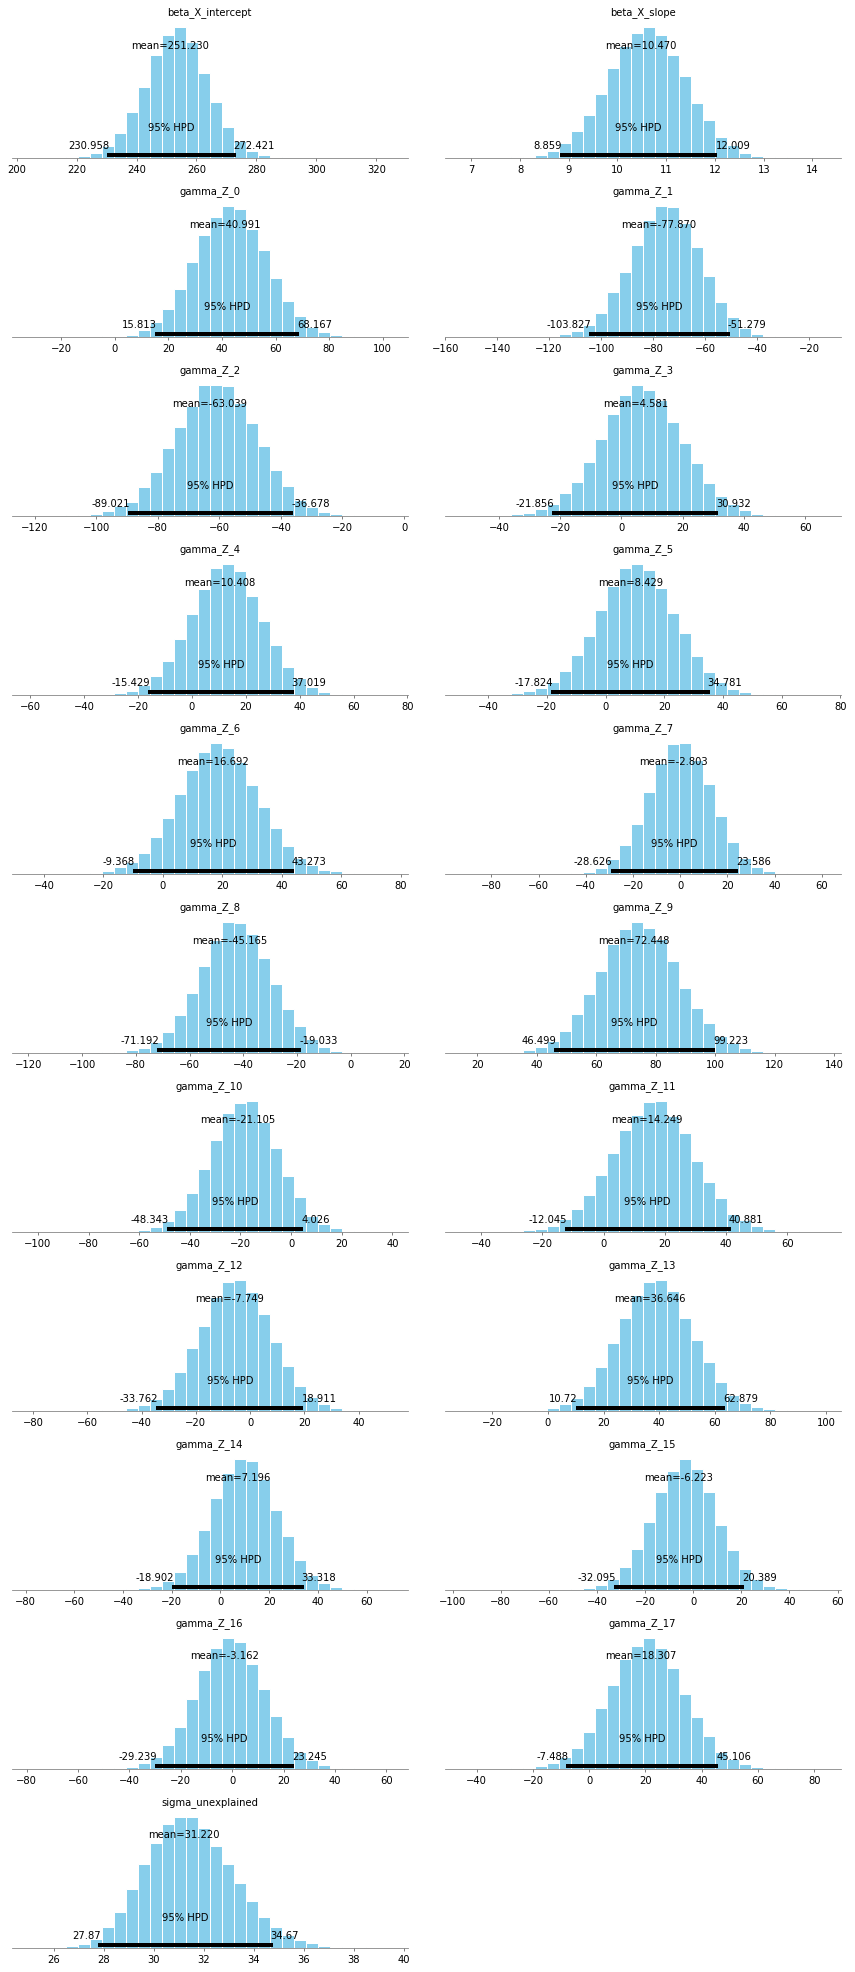

In [12]:
pm.plot_posterior(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [13]:
trace_df = pm.trace_to_dataframe(trace_intercept)

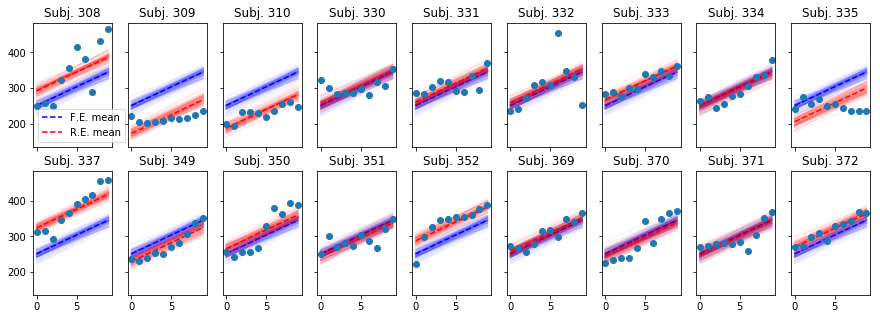

In [14]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0 in zip(trace_df['beta_X_intercept'][::500], 
                  trace_df['beta_X_slope'][::500],
                  trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + days * b1, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|█████████████████████| 250/250 [00:00<00:00, 1158.07it/s]


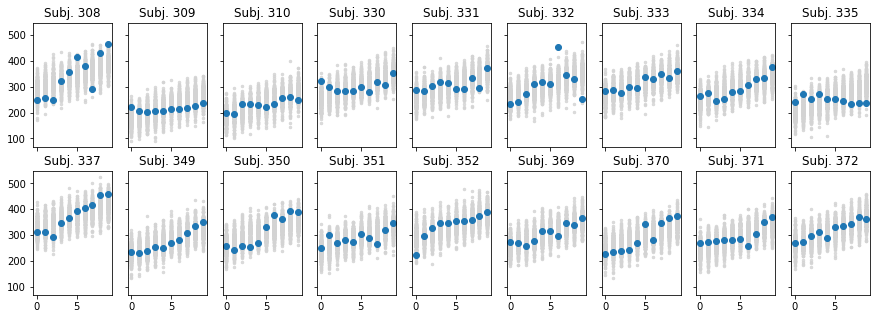

In [15]:
ppc = pm.sample_ppc(trace_intercept, samples=250, model=model_intercept)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [16]:
waic = pm.waic(trace_intercept, model_intercept, progressbar=True)
waic.WAIC

40000it [00:03, 10368.62it/s]
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1769.2494514024613

In [17]:
loo = pm.loo(trace_intercept, model_intercept)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1769.8508400581336

## Include second order coefficients

In [18]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.

In [19]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [20]:
with pm.Model() as model_intercept_pow2:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)

    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    scaler_Z = pm.HalfNormal('scaler_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, scaler_Z, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


In [21]:
trace_intercept_pow2 = trace_intercept_pow2[BURNIN: ]

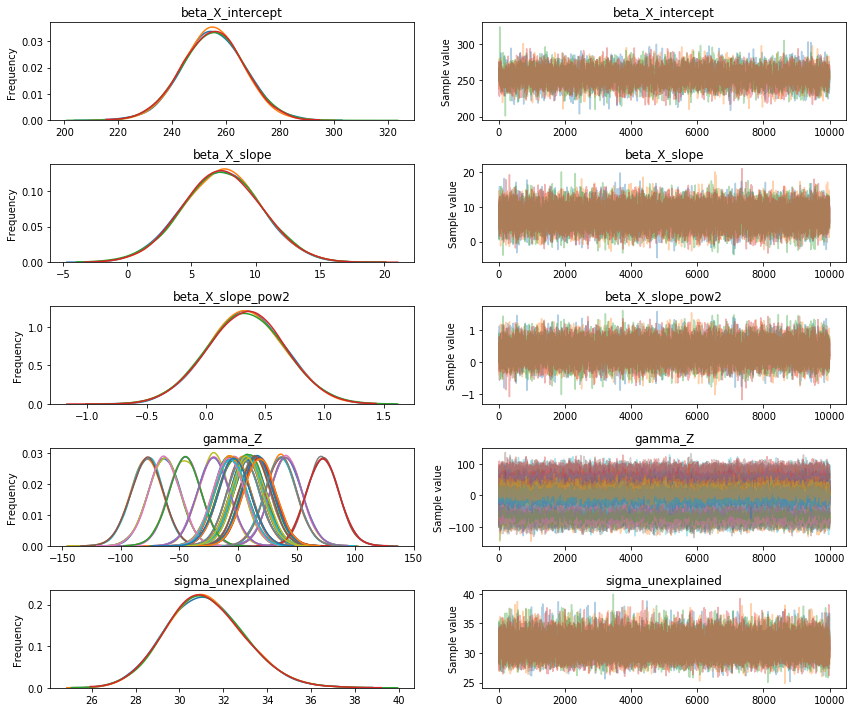

In [22]:
_ = pm.traceplot(trace_intercept_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z', 'sigma_unexplained'])

In [23]:
pm.summary(trace_intercept_pow2)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope         7.405522   3.010835  0.025927    1.461766   13.264961   
beta_X_slope_pow2    0.339532   0.322254  0.002725   -0.307739    0.957346   
gamma_Z_raw__0       1.059612   0.380300  0.004609    0.336496    1.825014   
gamma_Z_raw__1      -2.007713   0.476166  0.005772   -2.941201   -1.077285   
gamma_Z_raw__2      -1.625373   0.434992  0.005071   -2.470692   -0.770681   
gamma_Z_raw__3       0.117542   0.340499  0.003805   -0.535654    0.796438   
gamma_Z_raw__4       0.267395   0.344035  0.003993   -0.417376    0.942857   
gamma_Z_raw__5       0.217182   0.340710  0.003763   -0.464365    0.876123   
gamma_Z_raw__6       0.429392   0.346641  0.003961   -0.240096    1.117238   
gamma_Z_raw__7      -0.072754   0.341042  0.004026   -0.746216    0.584457   
gamma_Z_raw__8      -1.166287   0.394196  0.004826   -1.942274   -0.393157   
gamma_Z_raw__9       1.869726   0.454200  0.005884    0.973601    2.754302   
gamma_Z_raw__10     -0.542121   0.354059  0.004097   -1.236213    0.153389   
gamma_Z_raw__11      0.368640   0.342616  0.003977   -0.294436    1.043592   
gamma_Z_raw__12     -0.197915   0.342851  0.003745   -0.875846    0.470727   
gamma_Z_raw__13      0.945438   0.373293  0.004479    0.212712    1.668689   
gamma_Z_raw__14      0.185782   0.340986  0.003932   -0.470071    0.871522   
gamma_Z_raw__15     -0.159270   0.341699  0.003743   -0.825026    0.512292   
gamma_Z_raw__16     -0.082863   0.342544  0.003758   -0.770414    0.575102   
gamma_Z_raw__17      0.473652   0.348298  0.004162   -0.202481    1.157825   
beta_X_intercept   255.285171  11.397773  0.162496  232.805638  277.726961   
scaler_Z            40.051995   7.981743  0.103331   26.609835   56.502793   
gamma_Z__0          41.130596  13.490566  0.151831   14.669247   67.760718   
gamma_Z__1         -77.815864  13.530747  0.151369 -104.205657  -51.282401   
gamma_Z__2         -62.987155  13.476359  0.147153  -89.766522  -36.660776   
gamma_Z__3           4.610246  13.437884  0.150826  -21.577660   31.054020   
gamma_Z__4          10.409326  13.518563  0.158260  -16.592766   36.572301   
gamma_Z__5           8.459176  13.397269  0.149143  -17.654408   35.027058   
gamma_Z__6          16.703471  13.463878  0.150781   -9.919797   43.077115   
gamma_Z__7          -2.776457  13.451959  0.160784  -30.063706   22.800878   
gamma_Z__8         -45.176567  13.513149  0.160219  -72.150535  -19.212538   
gamma_Z__9          72.540083  13.529580  0.151494   46.875979   99.777599   
gamma_Z__10        -20.967577  13.422879  0.158915  -47.180945    5.539692   
gamma_Z__11         14.332765  13.375904  0.152764  -12.365455   40.076900   
gamma_Z__12         -7.647448  13.452529  0.148724  -33.629225   19.216472   
gamma_Z__13         36.691542  13.498576  0.155705   10.071860   63.179449   
gamma_Z__14          7.261618  13.448424  0.155591  -18.854504   34.016967   
gamma_Z__15         -6.127417  13.434496  0.150710  -31.753429   20.826639   
gamma_Z__16         -3.169864  13.500302  0.150450  -29.410159   23.475777   
gamma_Z__17         18.420548  13.472704  0.159727   -7.509401   45.243967   
sigma_unexplained   31.215424   1.771907  0.010491   27.836072   34.748133   

                          n_eff      Rhat  
beta_X_slope       15116.403207  1.000029  
beta_X_slope_pow2  15419.030330  1.000026  
gamma_Z_raw__0      7561.511461  1.000274  
gamma_Z_raw__1      7362.999355  1.000145  
gamma_Z_raw__2      7555.059814  1.000129  
gamma_Z_raw__3      8047.642222  1.000138  
gamma_Z_raw__4      7748.534542  1.000058  
gamma_Z_raw__5      7908.152913  1.000063  
gamma_Z_raw__6      7590.179880  1.000116  
gamma_Z_raw__7      7700.866087  1.000068  
gamma_Z_raw__8      7844.971946  1.000105  
gamma_Z_raw__9      7102.361973  1.000591  
gamma_Z_raw__10     7646.104531  0.999978  
gamma_Z_raw__11     7744.682638  1.000049  
gamma_Z_raw__12     8198.579899  0.999997  
gamma_Z_raw__13     7645.759654  1.000186  


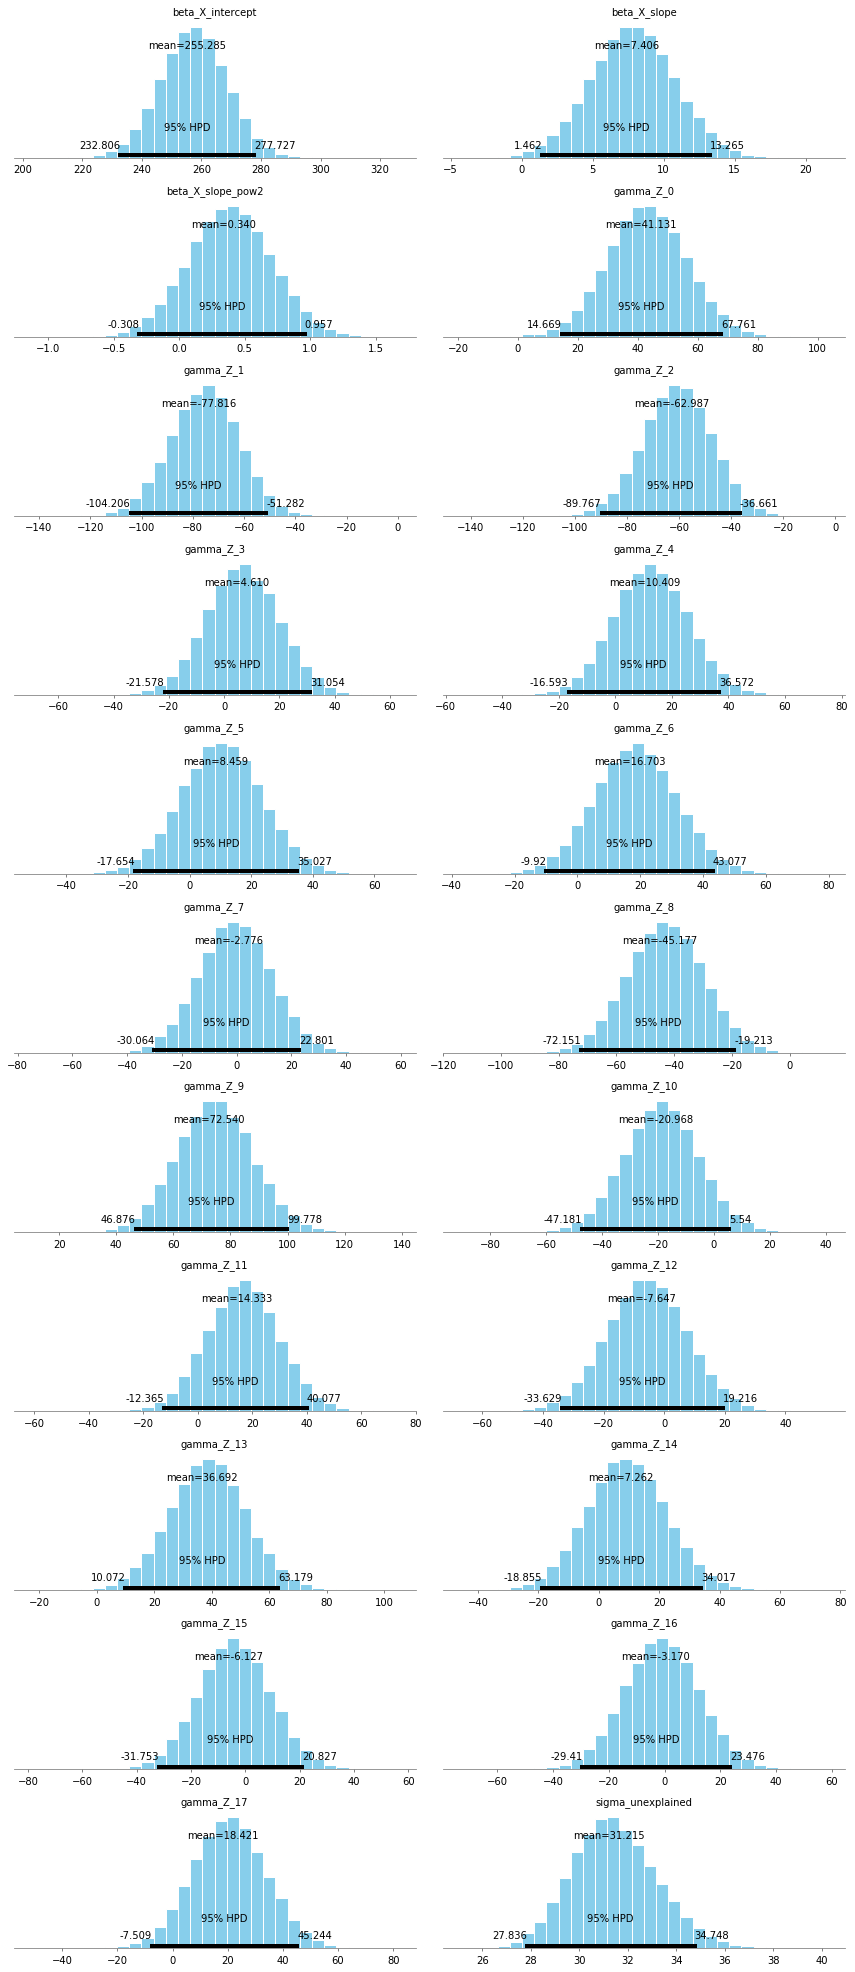

In [24]:
pm.plot_posterior(trace_intercept_pow2, varnames=['beta_X_intercept', 'beta_X_slope',  'beta_X_slope_pow2',  'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [25]:
trace_df = pm.trace_to_dataframe(trace_intercept_pow2)

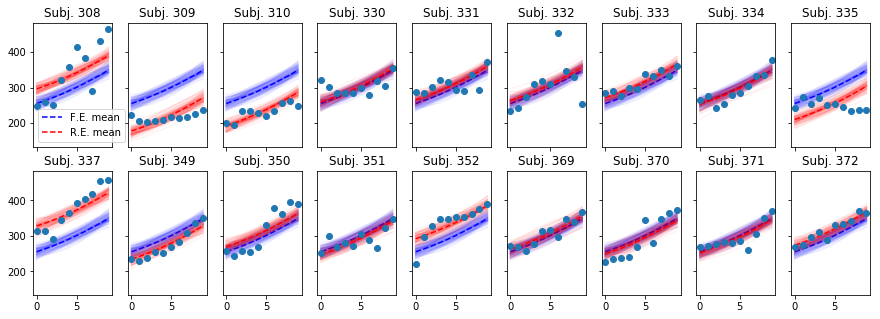

In [26]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500]):
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, 
               trace_df['beta_X_intercept'].mean() + \
               days*trace_df['beta_X_slope'].mean() + \
               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 ,b2, g0 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500],
                      trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, 
                   b0 + g0 + \
                   days * b1 + \
                   (days**2) * b2, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean() + \
               (days**2) * trace_df['beta_X_slope_pow2'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|█████████████████████| 250/250 [00:00<00:00, 1272.89it/s]


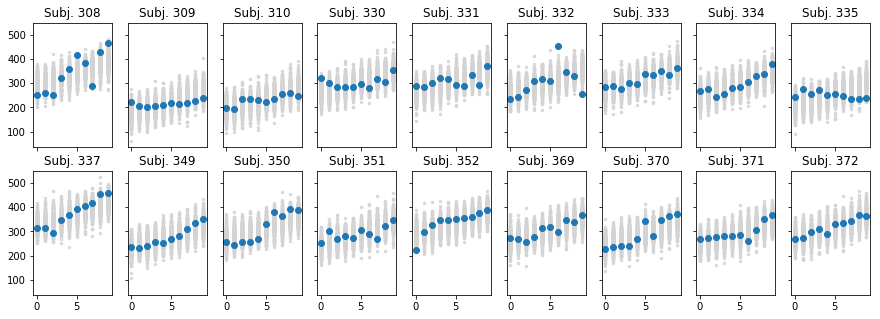

In [27]:
ppc = pm.sample_ppc(trace_intercept_pow2, samples=250, model=model_intercept_pow2)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [28]:
waic = pm.waic(trace_intercept_pow2, model_intercept_pow2, progressbar=True)
waic.WAIC

40000it [00:05, 7089.97it/s]
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1770.6769600981277

In [29]:
loo = pm.loo(trace_intercept_pow2, model_intercept_pow2)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1771.3743772437824

## Random effect on the slopes only

In [30]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [31]:
Z = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [32]:
Y = np.asarray(sleep['Reaction'])

In [33]:
with pm.Model() as model_slope:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler = pm.HalfNormal('scaler', sd=100)
    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler)
    
    estimate_Z = pm.math.dot(Z, gamma_Z) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace_slope = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, scaler, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


In [34]:
trace_slope = trace_slope[BURNIN: ]

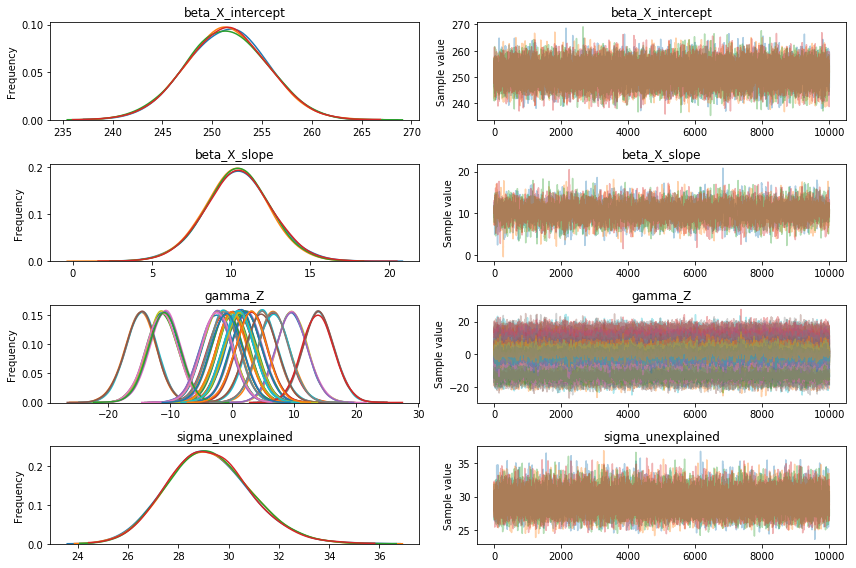

In [35]:
_ = pm.traceplot(trace_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained'])

In [36]:
pm.summary(trace_slope)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope        10.433731   2.027644  0.029246    6.347823   14.408803   
gamma_Z_raw__0       1.268768   0.381470  0.004362    0.550640    2.043746   
gamma_Z_raw__1      -1.933833   0.462351  0.005687   -2.860347   -1.060819   
gamma_Z_raw__2      -1.484532   0.412368  0.005127   -2.300916   -0.683304   
gamma_Z_raw__3      -0.174909   0.322429  0.003646   -0.812873    0.447002   
gamma_Z_raw__4       0.029867   0.320307  0.003558   -0.594083    0.658942   
gamma_Z_raw__5       0.141752   0.320253  0.003458   -0.497576    0.756061   
gamma_Z_raw__6       0.302781   0.324943  0.003780   -0.326553    0.947113   
gamma_Z_raw__7       0.002585   0.322092  0.003692   -0.612539    0.645795   
gamma_Z_raw__8      -1.434699   0.405911  0.005001   -2.230642   -0.646565   
gamma_Z_raw__9       1.831484   0.441432  0.005407    0.993715    2.714180   
gamma_Z_raw__10     -0.335758   0.329142  0.003887   -0.974101    0.316395   
gamma_Z_raw__11      0.625100   0.335374  0.004068   -0.031822    1.280579   
gamma_Z_raw__12     -0.308399   0.324561  0.003933   -0.957139    0.314842   
gamma_Z_raw__13      0.880327   0.352223  0.004090    0.214781    1.603160   
gamma_Z_raw__14      0.182806   0.322805  0.003647   -0.440830    0.826934   
gamma_Z_raw__15      0.142622   0.321828  0.003689   -0.494928    0.770879   
gamma_Z_raw__16     -0.111899   0.323497  0.003895   -0.744059    0.516013   
gamma_Z_raw__17      0.412534   0.327292  0.003674   -0.221674    1.063154   
beta_X_intercept   251.450207   4.055512  0.026944  243.721329  259.613357   
scaler               7.866436   1.579352  0.020379    5.125677   10.988901   
gamma_Z__0           9.662612   2.499708  0.028757    4.848510   14.657637   
gamma_Z__1         -14.700452   2.503543  0.028115  -19.649415   -9.790424   
gamma_Z__2         -11.282403   2.505182  0.029487  -16.218939   -6.361681   
gamma_Z__3          -1.320385   2.489128  0.029299   -6.263734    3.528054   
gamma_Z__4           0.237789   2.492712  0.028983   -4.673461    5.135687   
gamma_Z__5           1.090269   2.495077  0.027998   -3.820278    5.977216   
gamma_Z__6           2.315068   2.499308  0.030023   -2.543946    7.253591   
gamma_Z__7           0.031863   2.501969  0.029549   -4.915241    4.873968   
gamma_Z__8         -10.903248   2.492764  0.028825  -15.942988   -6.107989   
...                       ...        ...       ...         ...         ...   
mu_estimate__151   262.978647   3.825422  0.025537  255.423905  270.403928   
mu_estimate__152   274.507088   4.403982  0.027385  265.694674  282.890097   
mu_estimate__153   286.035528   5.543536  0.031926  274.687157  296.395755   
mu_estimate__154   297.563969   6.974314  0.038214  283.979061  311.113611   
mu_estimate__155   309.092409   8.551365  0.045529  292.156281  325.534142   
mu_estimate__156   320.620850  10.207113  0.053452  300.994923  340.898361   
mu_estimate__157   332.149290  11.908778  0.061748  309.063841  355.632516   
mu_estimate__158   343.677731  13.639184  0.070287  317.409713  370.786554   
mu_estimate__159   355.206171  15.388640  0.078989  324.814901  385.023278   
mu_estimate__160   251.450207   4.055512  0.026944  243.721329  259.613357   
mu_estimate__161   261.044291   3.809906  0.024843  253.388071  268.303504   
mu_estimate__162   270.638375   4.381121  0.024871  261.924024  279.066190   
mu_estimate__163   280.232459   5.521204  0.027022  269.250037  290.822376   
mu_estimate__164   289.826543   6.955846  0.030856  275.871949  302.849461   
mu_estimate__165   299.420628   8.537830  0.035836  282.724251  315.785719   
mu_estimate__166   309.014712  10.198819  0.041552  288.889347  328.440073   
mu_estimate__167   318.608796  11.905793  0.047740  295.335514  341.618941   
mu_estimate__168   328.202880  13.641501  0.054239  301.241399  354.428691   
mu_estimate__169   337.796964  15.396227  0.060950  308.063118  368.126533   
mu_estimate__170   251.450207   4.055512  0.026

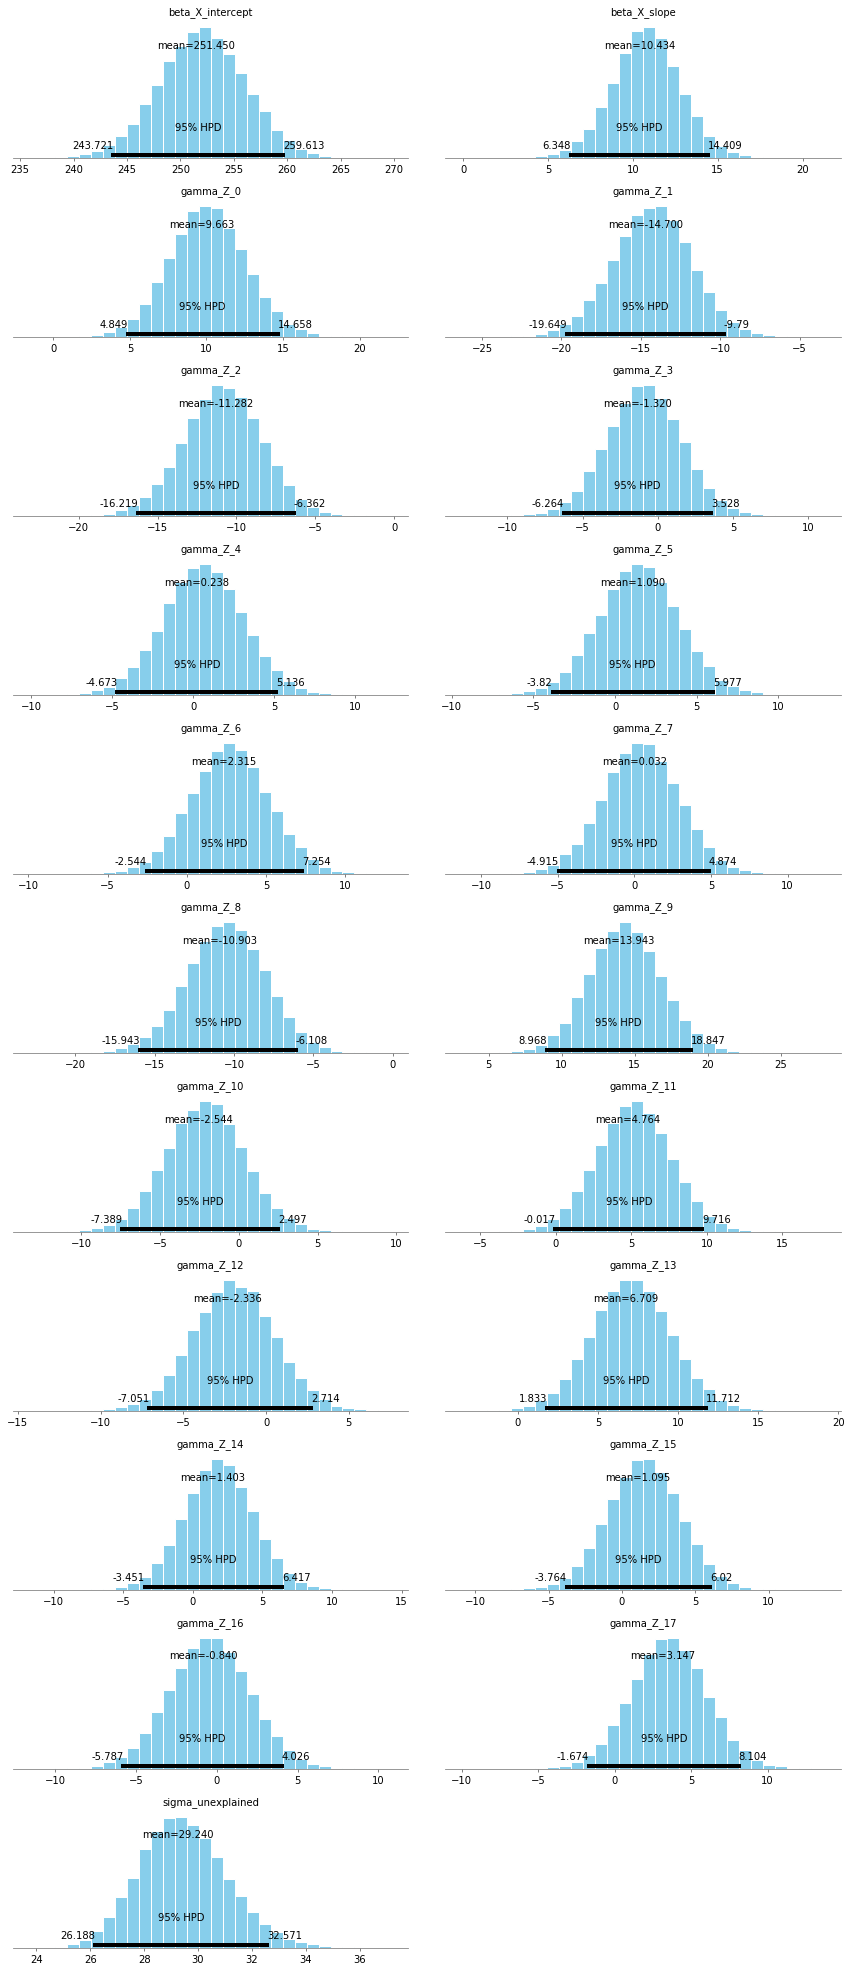

In [37]:
pm.plot_posterior(trace_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [38]:
trace_df = pm.trace_to_dataframe(trace_slope)

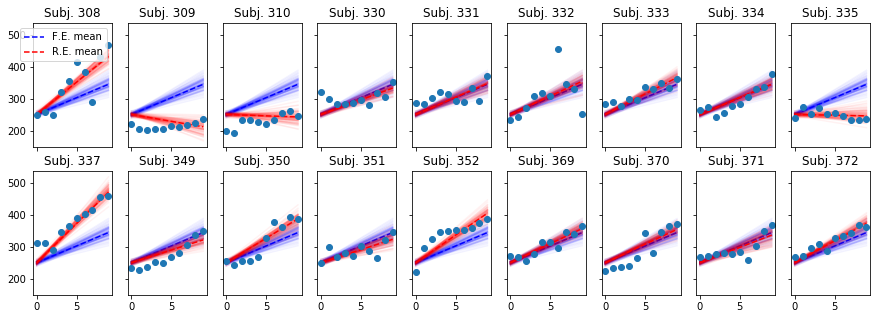

In [39]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g1 in zip(trace_df['beta_X_intercept'][::500], 
                  trace_df['beta_X_slope'][::500],
                  trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, b0 + 
                   days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|█████████████████████| 250/250 [00:00<00:00, 1397.45it/s]


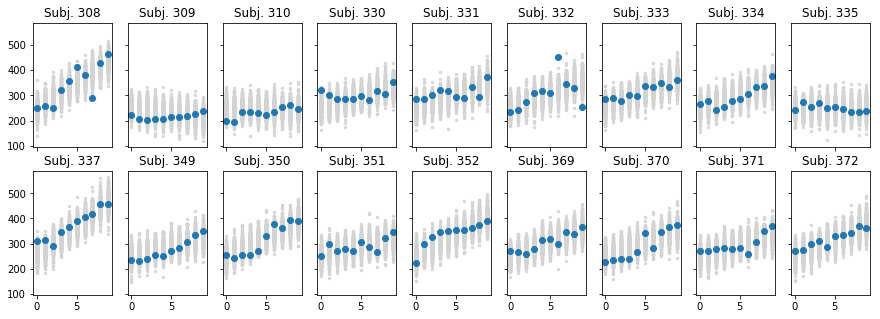

In [40]:
ppc = pm.sample_ppc(trace_slope, samples=250, model=model_slope)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [41]:
waic = pm.waic(trace_slope, model_slope)
waic.WAIC

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1748.2799464489306

In [42]:
loo = pm.loo(trace_slope, model_slope)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1750.431179137939

## Include second order coefficients

In [43]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.

In [44]:
Z = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [45]:
with pm.Model() as model_slope_pow2:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)

    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    scaler_Z = pm.HalfNormal('scaler_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * scaler_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_slope_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, scaler_Z, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
The number of effective samples is smaller than 25% for some parameters.


In [46]:
trace_slope_pow2 = trace_slope_pow2[BURNIN: ]

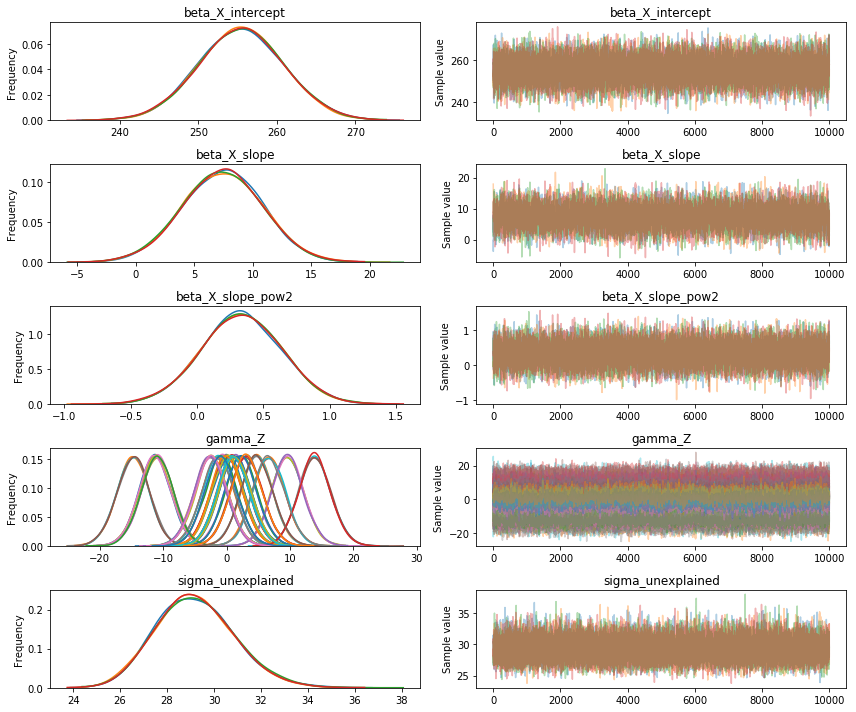

In [47]:
_ = pm.traceplot(trace_slope_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z', 'sigma_unexplained'])

In [48]:
pm.summary(trace_slope_pow2)

mean        sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope         7.427306  3.399237  0.039636    0.923747   14.249232   
beta_X_slope_pow2    0.336532  0.298995  0.002159   -0.255613    0.920636   
gamma_Z_raw__0       1.264950  0.385363  0.004278    0.508749    2.008248   
gamma_Z_raw__1      -1.933503  0.463681  0.005986   -2.847670   -1.041614   
gamma_Z_raw__2      -1.482117  0.411199  0.005174   -2.287181   -0.689661   
gamma_Z_raw__3      -0.175289  0.326424  0.003694   -0.825511    0.450783   
gamma_Z_raw__4       0.027183  0.323137  0.003730   -0.621656    0.647631   
gamma_Z_raw__5       0.140884  0.323021  0.003606   -0.491568    0.774523   
gamma_Z_raw__6       0.298334  0.326005  0.003664   -0.354443    0.924126   
gamma_Z_raw__7       0.001195  0.322014  0.003663   -0.653735    0.612488   
gamma_Z_raw__8      -1.432497  0.407299  0.005153   -2.243994   -0.648095   
gamma_Z_raw__9       1.825183  0.446238  0.005063    0.970289    2.710237   
gamma_Z_raw__10     -0.335416  0.329461  0.003732   -0.971360    0.320667   
gamma_Z_raw__11      0.624418  0.336237  0.003573   -0.040410    1.273280   
gamma_Z_raw__12     -0.311202  0.327428  0.003802   -0.952636    0.330620   
gamma_Z_raw__13      0.876537  0.354267  0.003740    0.199729    1.581957   
gamma_Z_raw__14      0.180236  0.322819  0.003467   -0.444231    0.819460   
gamma_Z_raw__15      0.141657  0.322221  0.003642   -0.477719    0.781926   
gamma_Z_raw__16     -0.115652  0.323290  0.003596   -0.746891    0.518412   
gamma_Z_raw__17      0.411578  0.329595  0.003657   -0.219714    1.071846   
beta_X_intercept   255.454816  5.407693  0.037368  245.025233  266.204857   
scaler_Z             7.886805  1.590648  0.019695    5.097783   11.036987   
gamma_Z__0           9.647280  2.511810  0.029311    4.744388   14.598549   
gamma_Z__1         -14.736575  2.526892  0.028305  -19.733145   -9.777793   
gamma_Z__2         -11.295698  2.515061  0.027907  -16.296318   -6.378372   
gamma_Z__3          -1.332152  2.525170  0.028567   -6.288692    3.662575   
gamma_Z__4           0.215597  2.518701  0.029524   -4.724937    5.137740   
gamma_Z__5           1.079674  2.512775  0.028817   -3.806198    6.050146   
gamma_Z__6           2.276299  2.510822  0.029781   -2.596648    7.275290   
gamma_Z__7           0.015527  2.506072  0.028975   -4.983858    4.858053   
gamma_Z__8         -10.916131  2.525853  0.028401  -15.971111   -5.947518   
gamma_Z__9          13.918050  2.519192  0.028318    9.045036   18.940858   
gamma_Z__10         -2.552490  2.520676  0.028411   -7.481636    2.404147   
gamma_Z__11          4.764520  2.493254  0.028037   -0.103766    9.707187   
gamma_Z__12         -2.366140  2.517072  0.028464   -7.279162    2.659338   
gamma_Z__13          6.688059  2.516150  0.027161    1.938819   11.818757   
gamma_Z__14          1.377209  2.510108  0.028053   -3.560360    6.293137   
gamma_Z__15          1.083351  2.504400  0.029388   -3.987536    5.836076   
gamma_Z__16         -0.876774  2.511789  0.028529   -5.772489    4.072214   
gamma_Z__17          3.143537  2.511524  0.029024   -1.562160    8.404152   
sigma_unexplained   29.207138  1.651588  0.009470   26.118217   32.545284   

                          n_eff      Rhat  
beta_X_slope        6905.400316  1.000059  
beta_X_slope_pow2  12861.693854  0.999979  
gamma_Z_raw__0      6264.383284  1.000005  
gamma_Z_raw__1      6579.278347  1.000096  
gamma_Z_raw__2      6562.680176  1.000146  
gamma_Z_raw__3      7580.468464  1.000051  
gamma_Z_raw__4      7380.906592  1.000071  
gamma_Z_raw__5      7324.497209  0.999983  
gamma_Z_raw__6      7159.224938  0.999981  
gamma_Z_raw__7      7454.011837  1.000093  
gamma_Z_raw__8      6718.214829  1.000116  
gamma_Z_raw__9      6208.178930  1.000030  
gamma_Z_raw__10     7462.946910  1.000004  
gamma_Z_raw__11     7262.703747  0.999959  
gamma_Z_raw__12     7568.881613  1.000099  
gamma_Z_raw__13     6982.206985  1.000037  
gamma_Z_raw__14     7505.543514  1.000044 

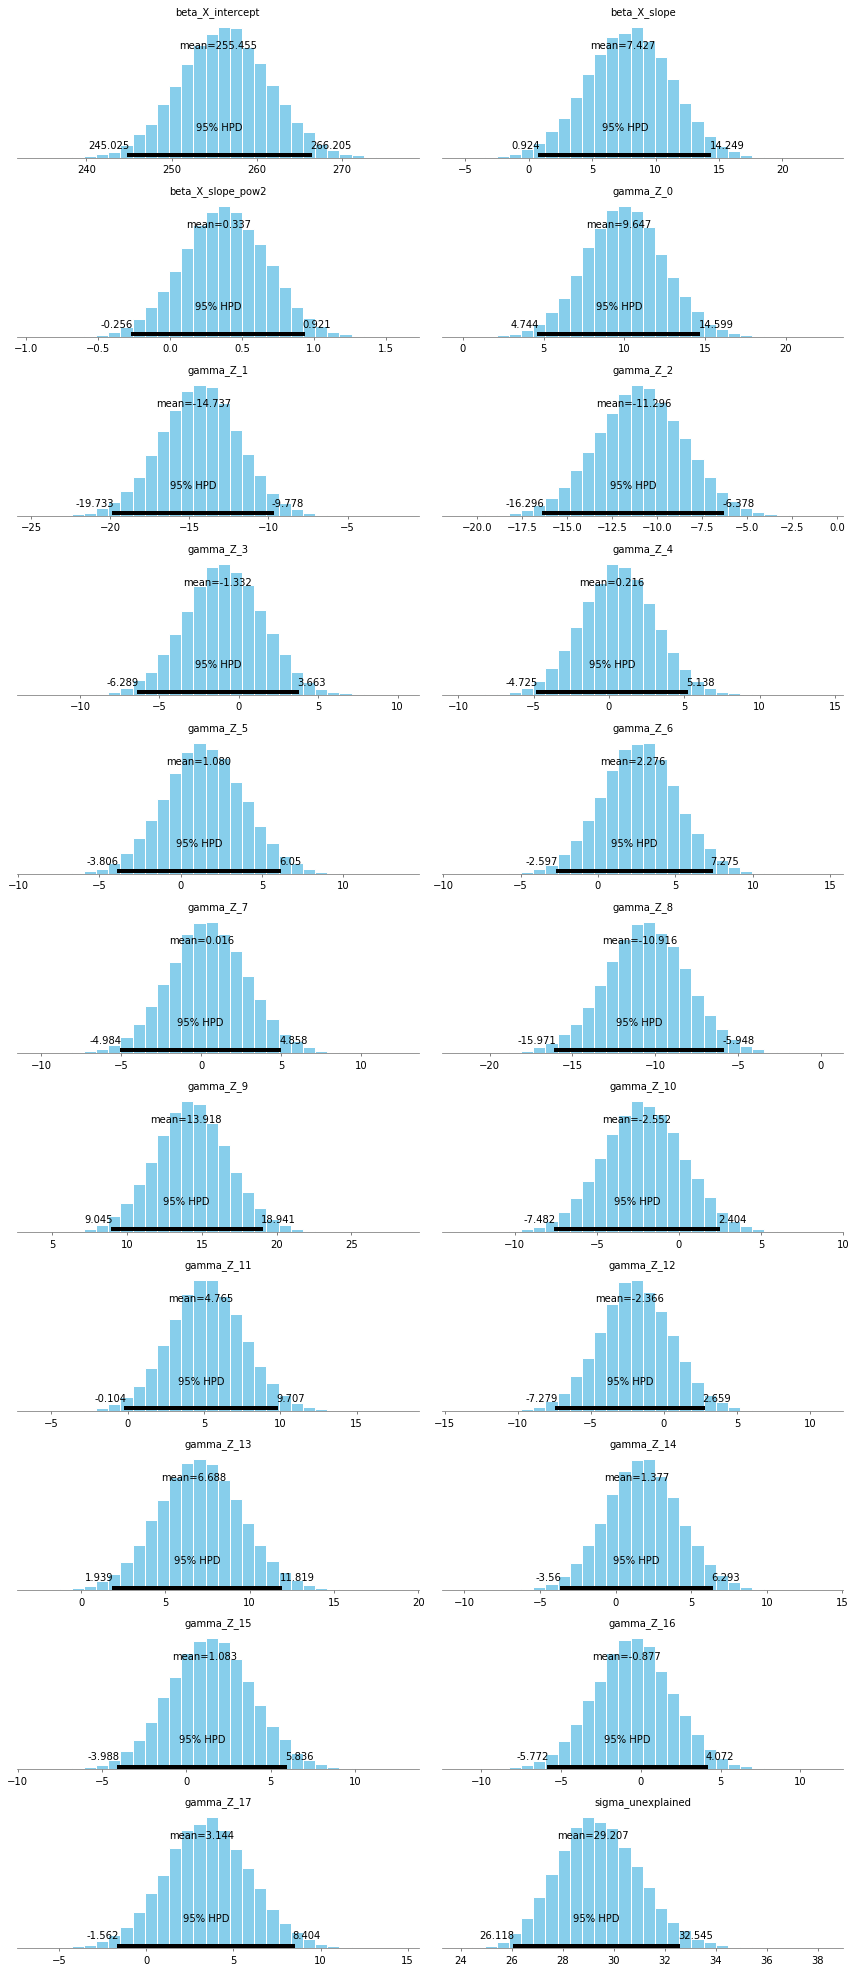

In [49]:
pm.plot_posterior(trace_slope_pow2, varnames=['beta_X_intercept', 'beta_X_slope',  'beta_X_slope_pow2',  'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [50]:
trace_df = pm.trace_to_dataframe(trace_slope_pow2)

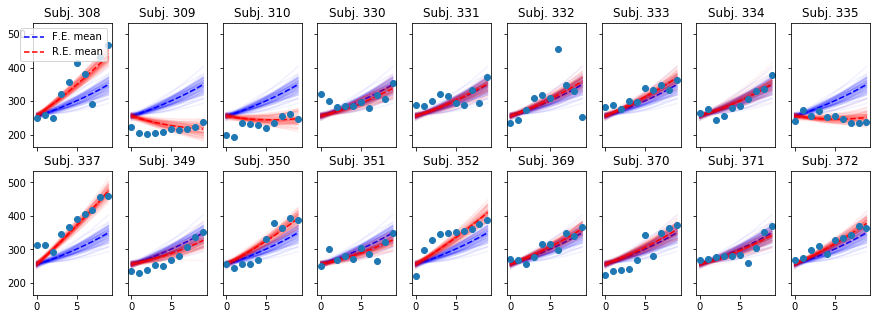

In [51]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500]):
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, 
               trace_df['beta_X_intercept'].mean() + \
               days*trace_df['beta_X_slope'].mean() + \
               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, b2, g1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500],
                      trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, 
                   b0 + days * (b1 + g1) + (days**2) * b2, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z__{}'.format(i)].mean()) + 
               (days**2) * trace_df['beta_X_slope_pow2'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|█████████████████████| 250/250 [00:00<00:00, 1352.12it/s]


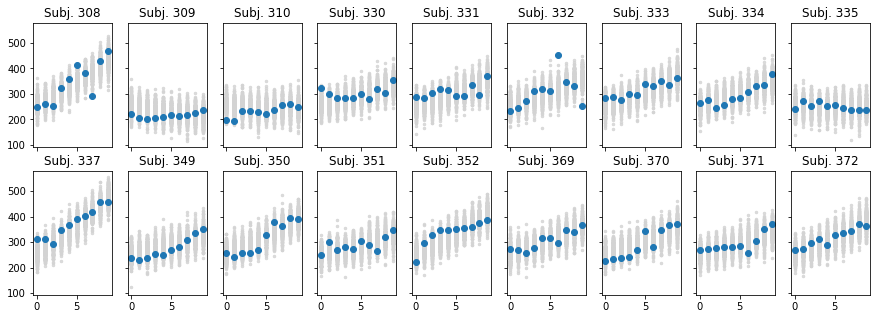

In [52]:
ppc = pm.sample_ppc(trace_slope_pow2, samples=250, model=model_slope_pow2)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [53]:
waic = pm.waic(trace_slope_pow2, model_slope_pow2, progressbar=True)
waic.WAIC

40000it [00:04, 9748.52it/s]
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1749.447179355795

In [54]:
loo = pm.loo(trace_slope_pow2, model_slope_pow2)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1751.6712462180549

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [55]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [56]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [57]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [58]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [59]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [60]:
Y = np.asarray(sleep['Reaction'])

In [61]:
with pm.Model() as model_intercept_slope:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler_intercept = pm.HalfNormal('scaler_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * scaler_intercept)

    scaler_slope = pm.HalfNormal('scaler_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * scaler_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_slope = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_slope_raw, scaler_slope, gamma_Z_intercept_raw, scaler_intercept, beta_X_slope, beta_X_intercept]


In [62]:
trace_intercept_slope = trace_intercept_slope[BURNIN: ]

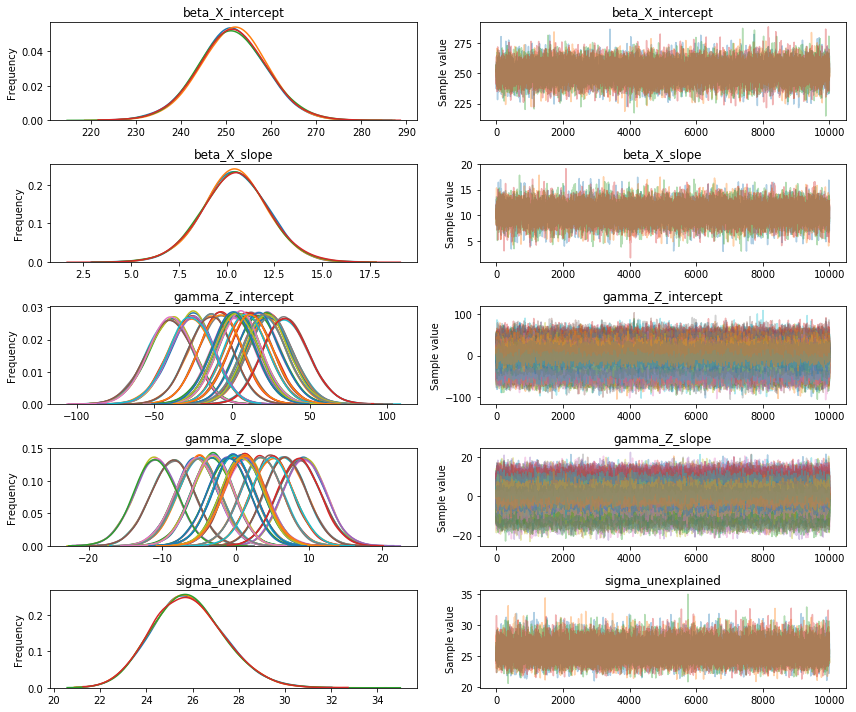

In [63]:
_ = pm.traceplot(trace_intercept_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z_intercept', 'gamma_Z_slope', 'sigma_unexplained'])

In [64]:
pm.summary(trace_intercept_slope)

mean         sd  mc_error     hpd_2.5  \
beta_X_slope                10.453059   1.707543  0.012222    7.092206   
gamma_Z_intercept_raw__0     0.047721   0.541850  0.002664   -1.032129   
gamma_Z_intercept_raw__1    -1.534496   0.572196  0.003064   -2.689103   
gamma_Z_intercept_raw__2    -1.494639   0.563715  0.003061   -2.634325   
gamma_Z_intercept_raw__3     0.940925   0.546882  0.002846   -0.153340   
gamma_Z_intercept_raw__4     0.876282   0.538194  0.002708   -0.142796   
gamma_Z_intercept_raw__5     0.351509   0.530758  0.002570   -0.679497   
gamma_Z_intercept_raw__6     0.653859   0.532129  0.002551   -0.371803   
gamma_Z_intercept_raw__7    -0.285885   0.528281  0.002290   -1.321275   
gamma_Z_intercept_raw__8     0.030389   0.542063  0.003020   -1.060797   
gamma_Z_intercept_raw__9     1.317498   0.557362  0.002969    0.237842   
gamma_Z_intercept_raw__10   -0.984747   0.544057  0.002889   -2.069932   
gamma_Z_intercept_raw__11   -0.537682   0.539043  0.002604   -1.601956   
gamma_Z_intercept_raw__12    0.187180   0.525140  0.002438   -0.848156   
gamma_Z_intercept_raw__13    0.793681   0.537343  0.002594   -0.259701   
gamma_Z_intercept_raw__14    0.121306   0.527039  0.002191   -0.912625   
gamma_Z_intercept_raw__15   -1.016764   0.549257  0.003084   -2.082064   
gamma_Z_intercept_raw__16    0.039145   0.529579  0.002851   -0.994320   
gamma_Z_intercept_raw__17    0.469165   0.534738  0.002739   -0.573158   
gamma_Z_slope_raw__0         1.492467   0.495794  0.002790    0.557586   
gamma_Z_slope_raw__1        -1.368091   0.496381  0.002654   -2.346561   
gamma_Z_slope_raw__2        -0.853152   0.470639  0.002523   -1.790503   
gamma_Z_slope_raw__3        -0.795453   0.464655  0.002652   -1.715823   
gamma_Z_slope_raw__4        -0.510624   0.451045  0.002401   -1.416392   
gamma_Z_slope_raw__5        -0.047455   0.446345  0.002394   -0.945362   
gamma_Z_slope_raw__6        -0.045877   0.443146  0.002187   -0.922585   
gamma_Z_slope_raw__7         0.180133   0.443684  0.002212   -0.703366   
gamma_Z_slope_raw__8        -1.740017   0.511323  0.003047   -2.763475   
gamma_Z_slope_raw__9         1.378284   0.497998  0.002789    0.403514   
gamma_Z_slope_raw__10        0.209705   0.451114  0.002282   -0.660220   
...                               ...        ...       ...         ...   
mu_estimate__151           240.185353  11.214466  0.055377  218.781515   
mu_estimate__152           255.670047   9.623182  0.047236  236.815078   
mu_estimate__153           271.154741   8.463562  0.041047  254.496789   
mu_estimate__154           286.639436   7.927360  0.037782  271.224159   
mu_estimate__155           302.124130   8.138738  0.038197  286.219083   
mu_estimate__156           317.608824   9.045439  0.042185  299.327861   
mu_estimate__157           333.093518  10.468322  0.048878  312.952719   
mu_estimate__158           348.578212  12.228510  0.057337  324.029857   
mu_estimate__159           364.062907  14.201128  0.066896  336.703227   
mu_estimate__160           252.482134  12.611075  0.054165  227.397951   
mu_estimate__161           261.923728  10.826691  0.047396  241.310029   
mu_estimate__162           271.365322   9.329864  0.042435  252.653766   
mu_estimate__163           280.806916   8.278080  0.039959  264.952271   
mu_estimate__164           290.248511   7.852260  0.040430  274.996594   
mu_estimate__165           299.690105   8.151103  0.043751  283.733637   
mu_estimate__166           309.131699   9.103521  0.049350  291.396573   
mu_estimate__167           318.573293  10.533700  0.056556  297.629035   
mu_estimate__168           328.014887  12.275777  0.064833  303.514078   
mu_estimate__169           337.456481  14.215543  0.073824  309.303034   
mu_estimate__170           263.819029  12.771838  0.053413  238.461771   
mu_estimate__171           275.542203  10.955605  0.045974  253.865085   
mu_estimate__172           287.265376   9.413443  0.039815  269.241981   
mu_estimate__173           298.988549

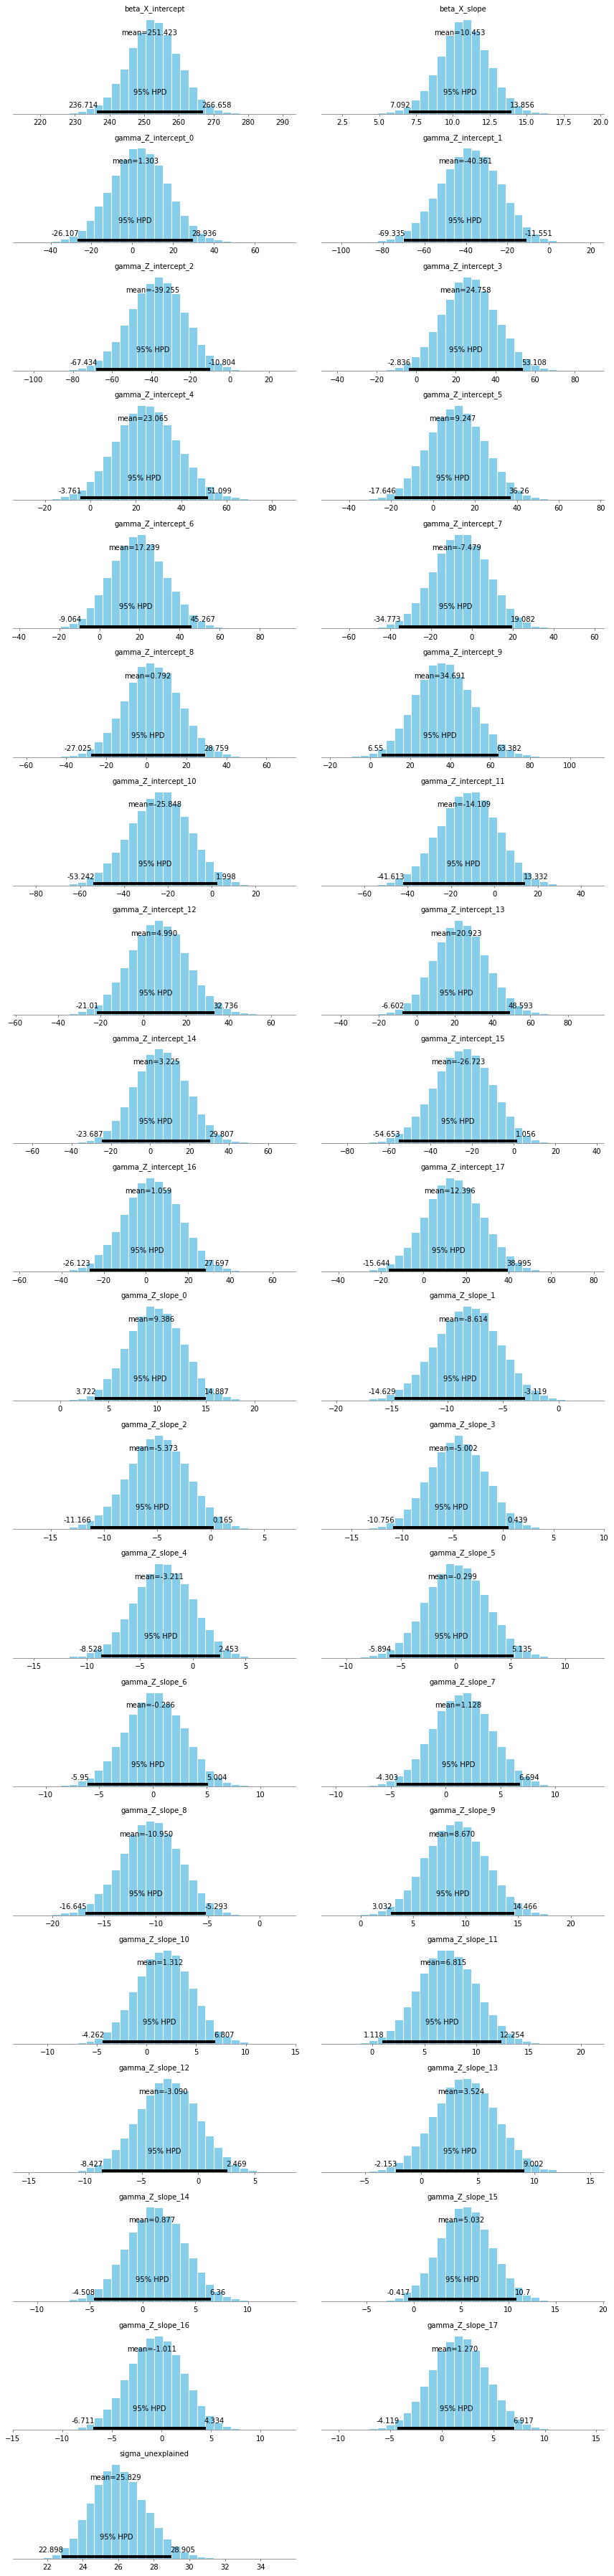

In [65]:
pm.plot_posterior(trace_intercept_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z_intercept', 'gamma_Z_slope', 'sigma_unexplained']);

In [66]:
trace_df = pm.trace_to_dataframe(trace_intercept_slope)
trace_df.head().T

0           1           2           3  \
beta_X_slope                11.405576    9.481937   11.021646   12.903516   
gamma_Z_intercept_raw__0     0.131560   -0.127459    0.735015    0.094293   
gamma_Z_intercept_raw__1    -1.805655   -1.719177   -1.066177   -0.946016   
gamma_Z_intercept_raw__2    -1.934945   -1.637158   -1.609774   -1.098713   
gamma_Z_intercept_raw__3     0.663020    0.895425    1.022105    1.515519   
gamma_Z_intercept_raw__4     0.776622    1.509873    1.057306    0.465758   
gamma_Z_intercept_raw__5     0.066052    0.204082    0.477752    0.612133   
gamma_Z_intercept_raw__6     0.210783    0.437631    0.840078    0.828769   
gamma_Z_intercept_raw__7    -0.049799   -0.099403   -0.086604   -0.100252   
gamma_Z_intercept_raw__8     0.286490    0.028475    0.200603    0.696094   
gamma_Z_intercept_raw__9     1.329039    0.527530    1.725681    1.772228   
gamma_Z_intercept_raw__10   -0.815011   -0.776426   -0.413465   -0.593987   
gamma_Z_intercept_raw__11   -0.908889   -1.187137    0.252025   -0.411870   
gamma_Z_intercept_raw__12   -0.612156    1.068106    0.397050    0.681718   
gamma_Z_intercept_raw__13    0.900656    1.496039    1.171345    1.083493   
gamma_Z_intercept_raw__14   -0.340969    0.008213    0.463463   -0.005618   
gamma_Z_intercept_raw__15   -0.717975   -0.763457    0.016348   -0.535253   
gamma_Z_intercept_raw__16    0.408088    0.191121    0.436420    0.837847   
gamma_Z_intercept_raw__17    0.749320    1.016416    1.741031    0.563706   
gamma_Z_slope_raw__0         1.313145    1.810610    2.196969    1.706340   
gamma_Z_slope_raw__1        -1.493998   -0.935514   -2.162406   -2.166175   
gamma_Z_slope_raw__2        -0.432777   -0.669982   -0.612004   -0.985260   
gamma_Z_slope_raw__3        -0.774567   -1.035830   -1.856073   -1.615107   
gamma_Z_slope_raw__4        -0.795089   -0.915965   -0.401724   -0.665155   
gamma_Z_slope_raw__5        -0.075934    0.046570   -0.092472   -0.537634   
gamma_Z_slope_raw__6        -0.038107   -0.007142   -0.368206   -0.106131   
gamma_Z_slope_raw__7         0.071804    0.116523    0.777904   -0.058507   
gamma_Z_slope_raw__8        -2.037036   -1.546101   -2.505351   -3.593367   
gamma_Z_slope_raw__9         1.237108    1.824326    1.372461    1.201786   
gamma_Z_slope_raw__10       -0.041128    0.267899    0.065425   -0.007005   
...                               ...         ...         ...         ...   
mu_estimate__151           244.082912  244.553080  250.443155  241.346571   
mu_estimate__152           259.173409  260.007385  263.076426  258.121064   
mu_estimate__153           274.263905  275.461690  275.709698  274.895557   
mu_estimate__154           289.354402  290.915995  288.342970  291.670051   
mu_estimate__155           304.444898  306.370300  300.976241  308.444544   
mu_estimate__156           319.535395  321.824605  313.609513  325.219037   
mu_estimate__157           334.625891  337.278910  326.242784  341.993530   
mu_estimate__158           349.716388  352.733215  338.876056  358.768023   
mu_estimate__159           364.806884  368.187520  351.509328  375.542516   
mu_estimate__160           263.091662  259.398107  251.046202  267.648672   
mu_estimate__161           271.006150  266.981179  259.492565  275.285720   
mu_estimate__162           278.920637  274.564251  267.938928  282.922769   
mu_estimate__163           286.835124  282.147323  276.385291  290.559818   
mu_estimate__164           294.749611  289.730395  284.831654  298.196866   
mu_estimate__165           302.664098  297.313467  293.278017  305.833915   
mu_estimate__166           310.578586  304.896539  301.724380  313.470964   
mu_estimate__167           318.493073  312.479611  310.170743  321.108012   
mu_estimate__168           326.407560  320.062683  318.617106  328.745061   
mu_estimate__169           334.322047  327.645754  327.063469  336.382110   
mu_estimate__170           273.424794  285.593848  292.154020  259.048377   
mu_estimate__171           281.5

## Posterior predictive check

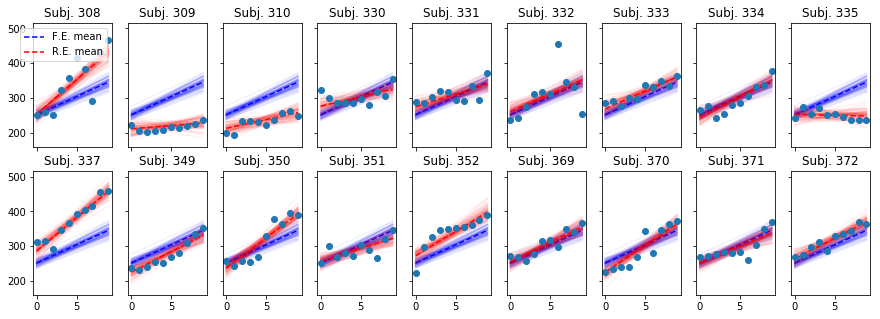

In [68]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0, g1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500],
                      trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

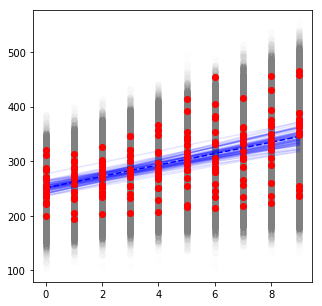

In [69]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


In [70]:
ppc = pm.sample_ppc(trace_intercept_slope, samples=250, model=model_intercept_slope)

100%|██████████████████████| 250/250 [00:00<00:00, 979.76it/s]


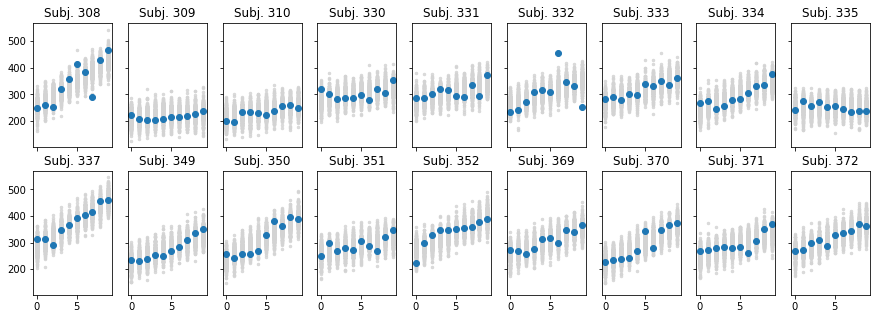

In [71]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


In [72]:
waic = pm.waic(trace_intercept_slope, model_intercept_slope)
waic.WAIC

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1718.7248066321727

In [73]:
loo = pm.loo(trace_intercept_slope, model_intercept_slope)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1722.0092727035137

## Include second order terms

In [74]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.

In [75]:
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z_slope_pow2 = patsy.dmatrix('0 + Subject:np.power(Days, 2)', data=sleep, return_type='dataframe')
Z_slope_pow2 = np.asarray(Z_slope_pow2)

Z = np.concatenate((Z_intercept, Z_slope, Z_slope_pow2), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z_slope_pow2 has shape ({}, {})'.format(*Z_slope_pow2.shape))

print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z_slope_pow2 has shape (180, 18)
Z has shape (180, 54)


In [76]:
Y = np.asarray(sleep['Reaction'])

In [77]:
with pm.Model() as model_intercept_slope_pow2:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    scaler_intercept = pm.HalfNormal('scaler_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * scaler_intercept)

    scaler_slope = pm.HalfNormal('scaler_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * scaler_slope)
    
    scaler_slope_pow2 = pm.HalfNormal('scaler_slope_pow2', sd=100)
    gamma_Z_slope_raw_pow2 = pm.Normal('gamma_Z_slope_raw_pow2', mu=0, sd=1, shape=Z_slope_pow2.shape[1])
    gamma_Z_slope_pow2 = pm.Deterministic('gamma_Z_slope_pow2', gamma_Z_slope_raw_pow2 * scaler_slope_pow2)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + \
                 pm.math.dot(Z_slope, gamma_Z_slope) + \
                 pm.math.dot(Z_slope_pow2, gamma_Z_slope_pow2)
        
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_slope_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_slope_raw_pow2, scaler_slope_pow2, gamma_Z_slope_raw, scaler_slope, gamma_Z_intercept_raw, scaler_intercept, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [78]:
trace_intercept_slope_pow2 = trace_intercept_slope_pow2[BURNIN: ]

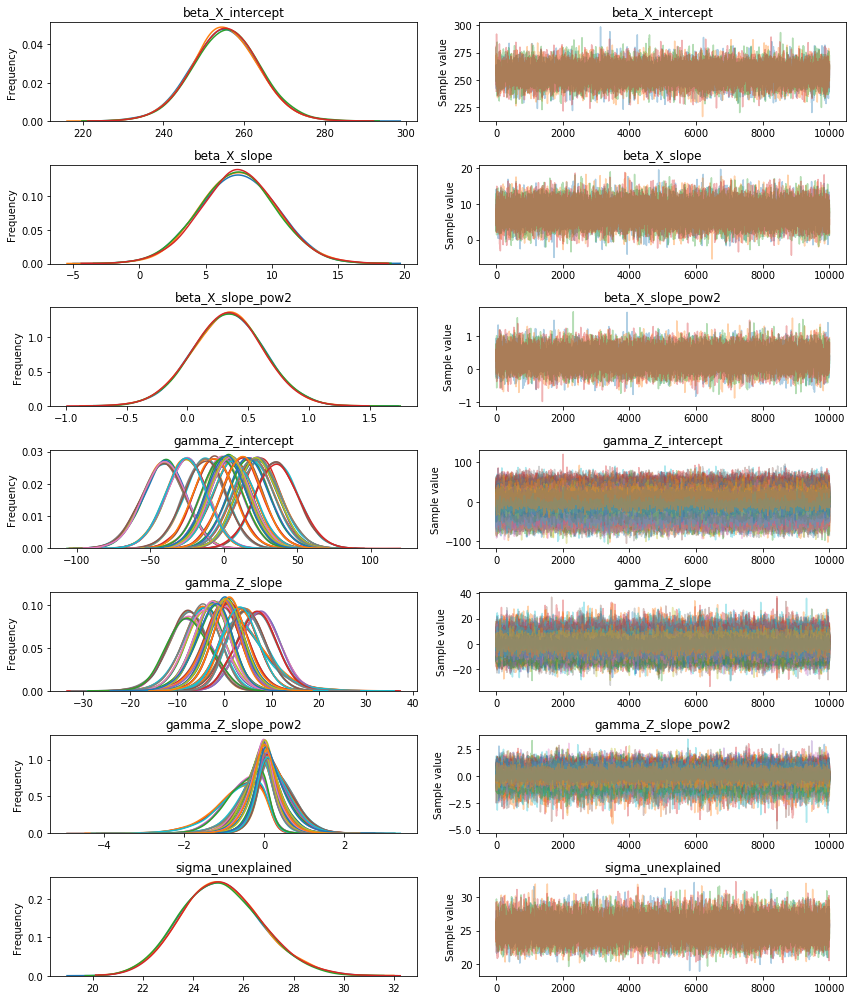

In [79]:
_ = pm.traceplot(trace_intercept_slope_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z_intercept', 'gamma_Z_slope', 'gamma_Z_slope_pow2', 'sigma_unexplained'])

In [80]:
trace_df = pm.trace_to_dataframe(trace_intercept_slope_pow2)

No handles with labels found to put in legend.


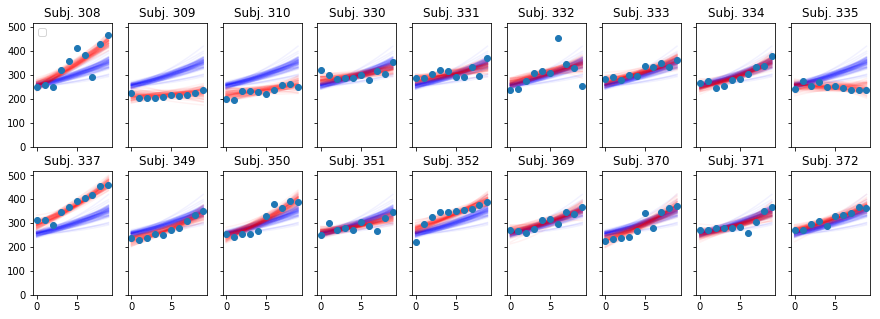

In [81]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                          trace_df['beta_X_slope'][::500], 
                          trace_df['beta_X_slope_pow2'][::500]):
        
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

#for i, subject in enumerate(subject_ids):
#    ax[i].plot(days, 
#               trace_df['beta_X_intercept'].mean() + \
#               days*trace_df['beta_X_slope'].mean() + \
#               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b', label='F.E. mean')

# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, b2, g0, g1, g2 in zip(trace_df['beta_X_intercept'][::500], 
                                      trace_df['beta_X_slope'][::500], 
                                      trace_df['beta_X_slope_pow2'][::500],
                                      trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                                      trace_df['gamma_Z_slope__{}'.format(i)][::500],
                                      trace_df['gamma_Z_slope_pow2__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + (b1 + g1)*days + (b2 + g2)*(days**2), '-r', alpha=0.05)
  
#for i, subject in enumerate(subject_ids):
#    ax[i].plot(days,
#               (trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean()) + 
#               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()) + 
#               (days**2) * (trace_df['beta_X_slope_pow2'].mean() + trace_df['gamma_Z_slope_pow2__{}'.format(i)].mean()), '--r', 
#               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

for axi in ax:
    axi.set_ylim(0, )
    
ax[0].legend();

In [82]:
ppc = pm.sample_ppc(trace_intercept_slope_pow2, samples=250, model=model_intercept_slope_pow2)

100%|██████████████████████| 250/250 [00:00<00:00, 879.24it/s]


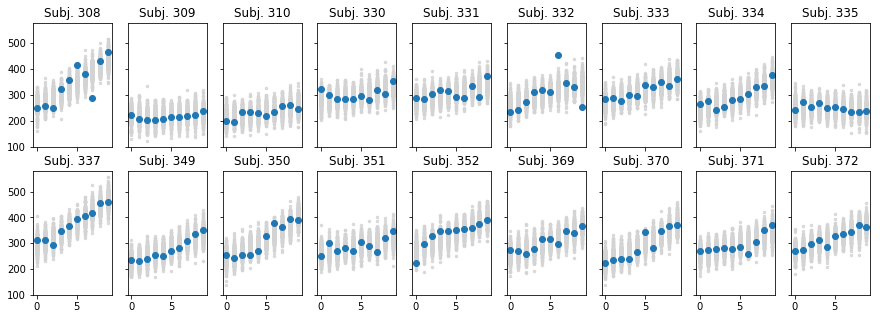

In [83]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


## Compare the first order models

In [84]:
# By setting the name of the model, the interpretation of the dataframe containing the comparison is easier. Otherwise, instead of the name, the index would be the order of insertion
model_intercept.name = 'model_intercept'
model_slope.name = 'model_slope'
model_intercept_slope.name = 'model_intercept_slope'

In [85]:
pm.compare({model_intercept: trace_intercept, 
            model_slope: trace_slope,
            model_intercept_slope: trace_intercept_slope}, ic='WAIC')

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
model_intercept_slope  1718.72  32.98      0    0.9  44.56      0        1
model_slope            1748.28  20.56  29.56      0  34.93  13.74        1
model_intercept        1769.25   19.1  50.52    0.1  28.53  23.35        1

In [86]:
pm.compare({model_intercept: trace_intercept, 
            model_slope: trace_slope,
            model_intercept_slope: trace_intercept_slope}, ic='LOO')

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO   pLOO   dLOO weight     SE    dSE shape_warn
model_intercept_slope  1722.01  34.62      0    0.9   45.4      0          1
model_slope            1750.43  21.63  28.42      0  35.66  13.88          1
model_intercept        1769.85   19.4  47.84    0.1  28.71  23.95          1

## Khatri Rao product to construct Z

In [ ]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

In [ ]:
X.shape

In [ ]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

In [ ]:
np.kron(J[0, :], X[0, :]).shape

In [ ]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [ ]:
Z_kr.shape

In [ ]:
Z.shape

In [ ]:
Z_kr[:10, :10]

In [ ]:
Z[-10:-1, -10:-1]